In [196]:
import os
from joblib import Parallel, delayed
import time
import numpy as np

In [197]:
os.system("aws --region us-west-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

os.system("aws --region us-west-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

0

In [198]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines

for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "MAKWest.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "MAKWest.pem" ubuntu@ec2-54-177-136-107.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-54-176-104-220.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-54-219-133-117.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-3-101-38-31.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-13-57-202-135.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-54-183-86-163.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-52-53-189-131.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-54-183-233-197.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-3-101-26-141.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-54-193-44-178.us-west-1.compute.amazonaws.com


## Set number of clusters

In [199]:
nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)


total_count = 8


nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-2]



# clientIps = lines[-(nclusters):]
clientIps = lines[-2:]



2


In [200]:
clientIps, no_cluster_yet_nodes

(['3.101.26.141', '54.193.44.178'], [])

## Functions

In [201]:
def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
        os.system(command)

        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S ./gradlew installDist'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S rm ../dump_files/nohup*.out; echo 1234 | sudo -S rm config*/currentView;'
        
        
        os.system(command)
        
        

        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 & echo $! > ../dump_files/jobID_s'+str(i)+'.txt'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)        
#         print(command)



def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(i-len(nodeIps)-len(no_cluster_yet_nodes))+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = ' killall java;killall nohup'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'killall java;killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = ' nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        print(command)

# for i in range(len(lines)):
#     run_basic_client_check(i)



def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11080 11081 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)   
        
        
def join_node2(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11090 11091 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 
        
def join_node3(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11100 11101 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 

## Compile Job

## Setup Client and nodeIPS

In [202]:
len(lines)

10

In [203]:
len(nodeIps), len(clientIps)

(8, 2)

## RUN SERVERS

In [178]:
for i in range(len(lines)):
    kill_java(i)

for i in range(len(lines)):
    clean_job(i)
    
compile_job(1)



java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
java: no process found
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
java: no process found
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
java: no process found
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
java: no process found
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
java: no process found
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
java: no process found
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitte


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1s
3 actionable tasks: 3 executed


Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


In [179]:
    
for i in range(len(lines)-2-len(no_cluster_yet_nodes)):
    print(i)
    run_server_node(i)

0
1
2
3
4
5
6
7


In [180]:
time.sleep(30)
!tail ../dump_files/nohup_s0.out -n 50

-- currentConsensusIdAsked activated
-- Received CID query from 3 with ID 3
-- Going to send back response to CID query with CID: -1
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@61dd025, remoteId: 3
-- Sent CID reply to replica 3 with ID 3
-- currentConsensusIdAsked activated
-- Received CID query from 1 with ID 4
-- Going to send back response to CID query with CID: -1
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@4278a03f, remoteId: 1
-- Sent CID reply to replica 1 with ID 4
-- currentConsensusIdAsked activated
-- Received CID query from 2 with ID 4
-- Going to send back response to CID query with CID: -1
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@147ed70f, remoteId: 2
-- Sent CID reply to replica 2 with ID 4
-- Tejas: Sending CID query with ID 4 to replicas [1, 2, 3]
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@147ed70f, remoteId: 2
-- Getting connecti

In [181]:


# for i in range(len(lines)):
#     kill_java(i)

In [182]:
len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)


10

## Run basic client

In [183]:
for i in range(len(nodeIps)+len(no_cluster_yet_nodes),len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)):
    run_basic_client(i)

In [184]:
time.sleep(20)

In [185]:

# time.sleep(30)
# run_server_node(8)
# time.sleep(15)
# join_node1(8)

# time.sleep(30)
# run_server_node(9)

# time.sleep(30)
# join_node2(9)

# time.sleep(30)
# run_server_node(10)
# time.sleep(30)
# join_node3(10)

In [186]:
# time.sleep(50)

# run_server_node(9)

time.sleep(30)
# join_node2(9)


# for i in [2]:
#     os.system('kill -9 `cat ../dump_files/jobID_s2.txt`')
    


time.sleep(80)



for i in range(len(lines)):
    kill_java(i)
    


java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java(6544): Operation not permitted
nohup: no process found
java(5306): Operation not permitted
java(5751): Operation not permitted
java

In [187]:
# for i in range(len(lines)):
#     kill_java(i)

## Main Job

In [188]:
def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 


In [189]:
## Byzantine Remote View Change

In [190]:
times ,thputs, lats = getTimesThputs('../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out')


'../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out'

'../dump_files/nohup_c8.out'

In [191]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


In [192]:
np.sum(thputs[:45])

2789.86

In [195]:
times

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
        86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
        97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
       108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130.])

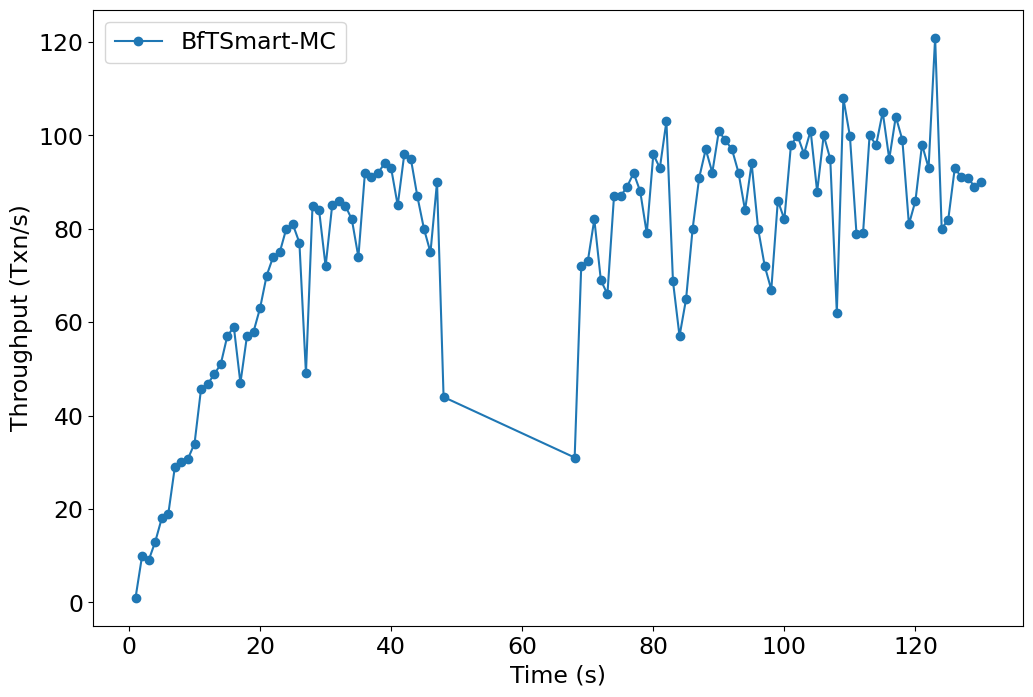

<Figure size 640x480 with 0 Axes>

In [193]:
import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
pl.show()
pl.clf()


In [194]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()
